# EDA

# Load Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import numpy as np
import warnings
import matplotlib as mpl
from matplotlib.transforms import Bbox
warnings.filterwarnings('ignore')

# Load Data

In [2]:
data = pd.read_csv("../data/processed/bank_cleaned.csv")

In [3]:
bank = data.copy()

# Inspect Data

In [4]:
bank.head()

,age,job,marital,education,default,housing,loan,contactType,month,dayOfWeek,...,currentCampaignContacts,daysLastContacted,previousCampaignContacts,lastCampaignOutcome,employmentRate,cpi,cci,euribor3m,noEmployed,response
0,56,housemaid,married,basic_4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high_school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high_school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic_6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high_school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [5]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       41188 non-null  int64  
 1   job                       41188 non-null  object 
 2   marital                   41188 non-null  object 
 3   education                 41188 non-null  object 
 4   default                   41188 non-null  object 
 5   housing                   41188 non-null  object 
 6   loan                      41188 non-null  object 
 7   contactType               41188 non-null  object 
 8   month                     41188 non-null  object 
 9   dayOfWeek                 41188 non-null  object 
 10  duration                  41188 non-null  int64  
 11  currentCampaignContacts   41188 non-null  int64  
 12  daysLastContacted         41188 non-null  int64  
 13  previousCampaignContacts  41188 non-null  int64  
 14  lastCa

## EDA Questions:

1. How do demographic variables (i.e. age, job category, marital status and level of education) influence whether or not a client subscribes for a term-depost?
2. How do financial history variables (i.e. default on past credit, possession a housing loan and possession of a personal loan) influence whether or not a client subscribes for a term-depost?
3. How do marketing variables (i.e. the way a client is contacted, month of contact, dayOfWeek of contact, duration of contact, number of times the client has been contaced during the current campaign, number of days since last contact, number of times the client was contaced during the last campaign, the outcome from the last campaign) influence whether or not a client subscribes for a term-depost?
4. How do macroeconomic variables (i.e. employment rate, consumer price index, consumer confidence index, euribor 3 months lending rate, number of employed) influence whether or not a client subscribes for a term-depost?
5. How do all these variables relate to each other?


# Review of The Marketing Response Variable

In [6]:
bank.response.value_counts(normalize = True)

no     0.887346
yes    0.112654
Name: response, dtype: float64

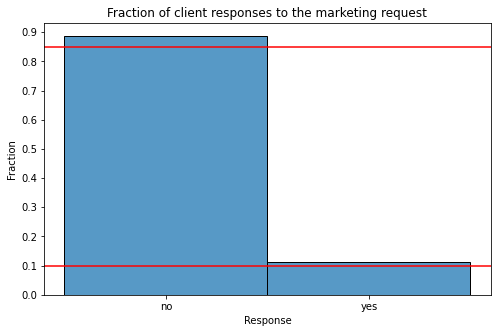

In [7]:
#Review distribution of response
plt.figure(figsize = (8, 5))
sns.histplot(data = bank, x = 'response', stat = 'density')
plt.title('Fraction of client responses to the marketing request')
plt.xlabel('Response')
plt.ylabel('Fraction')
plt.axhline(0.85, c = 'red')
plt.axhline(0.1, c = 'red')
plt.yticks(np.arange(0,1,0.1))
plt.savefig('..\\reports\\figures\\response.png', bbox_inches="tight")
plt.show();

We notice that over 85 percent of the clients said 'no' to the marketing request, with just over 10% of the clients responding positively to the request. The dataset is therefore imbalanced with respects to the marketing response.

# Influence of Demographic Variables on the Marketing Response

## Creating features and plotting Functions

In [8]:
def response_rate_cat(feature):
    global bank
    try:
       var = bank[f'{feature}_rr']
    except KeyError:
       var = None
    if var is None:
        df = bank.copy()
        df.response = df.response.replace({'yes': 1, 'no': 0})
        rate_df = pd.DataFrame(df.groupby(feature)['response'].mean()).reset_index(). \
                                rename(columns = {'response': f'{feature}_rr'})
        bank = pd.merge(bank, rate_df, on = f'{feature}', how = 'left')
    return bank

def categorical_plot(feature, figsize = (18, 8), rotation = 45, fontsize = 12, save = False):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = figsize)
    sns.countplot(data = bank, x = feature, order = bank[feature].value_counts().index, ax = ax1)
    ax1.set_title(f'Barplot of {feature}', fontsize = fontsize)
    ax1.set_xlabel(feature, fontsize = fontsize)
    ax1.set_ylabel('Count', fontsize = fontsize)
    ax1.tick_params(axis = 'x', rotation = rotation, labelsize = fontsize)
    ax1.tick_params(axis = 'y', labelsize = fontsize)

    
    sns.countplot(data = bank, hue = 'response', x = feature, \
                  order = bank[feature][(bank['response'] == 'yes')].value_counts().index, ax = ax2)
    ax2.set_title(f'Barplot of {feature} stratified by response', fontsize = fontsize)
    ax2.set_ylabel('Count', fontsize = fontsize)

    ax2.set_xlabel(feature, fontsize = fontsize)
    ax2.tick_params(axis = 'x', rotation = rotation, labelsize = fontsize)
    ax2.tick_params(axis = 'y', labelsize = fontsize)

    
    feat_order = bank.groupby([feature])[f'{feature}_rr'].max(). \
                 sort_values(ascending = False).index.astype('object')
    sns.barplot(data = bank, y = f'{feature}_rr', x = feature, order = feat_order)
    ax3.set_title(f'Positive response rate - {feature}', fontsize = fontsize)
    ax3.set_ylabel('Positive reponse rate', fontsize = fontsize)
    ax3.set_xlabel(feature, fontsize = fontsize)
    ax3.tick_params(axis = 'x', rotation = rotation, labelsize = fontsize)
    ax3.tick_params(axis = 'y', labelsize = fontsize)

    
    plt.tight_layout()
    if save:
        plt.savefig(f'..\\reports\\figures\\{feature}.png', bbox_inches="tight")
       
    
def feature_group(feature, bin_edges, labels):
    global bank
    new_bin_edges = bin_edges
    try:
       var = bank[f'{feature}_grp']
    except KeyError:
       var = None    
    if var is None:
        bank[f'{feature}_grp'] = pd.cut(bank[feature].values, bin_edges, labels = labels, include_lowest = True)
        df = bank.copy()
        df.response = df.response.replace({'yes': 1, 'no': 0})        
        response_df = pd.DataFrame(df.groupby(f'{feature}_grp')['response'].mean()).reset_index(). \
                                   rename(columns = {'response': f'{feature}_grp_rr'})
        bank = pd.merge(bank, response_df, on = f'{feature}_grp', how = 'left')       
    return bank
    
def numerical_plot(feature, figsize = (15, 12), rotation = 90, fontsize = 12, save = False, **kwargs):
    fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize = figsize)
    
    sns.boxplot(data = bank, x = 'response', y = feature, ax = ax1)
    ax1.set_title(f'Boxplot of {feature}', fontsize = fontsize)
    ax1.set_xlabel('response', fontsize = fontsize)
    if kwargs:
        for key, value in kwargs.items():
            ax1.set_ylabel(f'{feature} ({value})', fontsize = fontsize)
    else:
        ax1.set_ylabel(f'{feature}', fontsize = fontsize)
    ax1.tick_params(axis = 'x', rotation = rotation, labelsize = fontsize)
    ax1.tick_params(axis = 'y', labelsize = fontsize)
    
    sns.countplot(data = bank, x = f'{feature}_grp', order = bank[f'{feature}_grp'].value_counts().index, ax = ax2)
    ax2.set_title(f'Barplot of {feature} grp', fontsize = fontsize)
    if kwargs:
        for key, value in kwargs.items():
            ax2.set_xlabel(f'{feature} group ({value})', fontsize = fontsize)
    else:
        ax2.set_xlabel(f'{feature} group', fontsize = fontsize)
    ax2.set_ylabel('Count', fontsize = fontsize)
    ax2.tick_params(axis = 'x', rotation = rotation, labelsize = fontsize)
    ax2.tick_params(axis = 'y', labelsize = fontsize)

    
    sns.countplot(data = bank, x = f'{feature}_grp', hue = 'response', \
                  order = bank[f'{feature}_grp'][(bank['response'] == 'yes')].value_counts().index, ax = ax3)
    ax3.set_title(f'Distribution - {feature} grp and response', fontsize = fontsize)
    if kwargs:
        for key, value in kwargs.items():
            ax3.set_xlabel(f'{feature} group ({value})', fontsize = fontsize)
    else:
        ax3.set_xlabel(f'{feature} group', fontsize = fontsize)
    ax3.set_ylabel('Count', fontsize = fontsize)
    ax3.tick_params(axis = 'x', rotation = rotation, labelsize = fontsize)
    ax3.tick_params(axis = 'y', labelsize = fontsize)

    
    feat_order = bank.groupby([f'{feature}_grp'])[f'{feature}_grp_rr'].max(). \
                 sort_values(ascending = False).index.astype('object')
    sns.barplot(data = bank, y = f'{feature}_grp_rr', x = f'{feature}_grp', order = feat_order)
    ax4.set_title(f'Positive response rate - {feature} grp', fontsize = fontsize)
    if kwargs:
        for key, value in kwargs.items():
            ax4.set_xlabel(f'{feature} group ({value})', fontsize = fontsize)
    else:
        ax4.set_xlabel(f'{feature} group', fontsize = fontsize)
    ax4.set_ylabel('Positive reponse rate', fontsize = fontsize)
    ax4.tick_params(axis = 'x', rotation = rotation, labelsize = fontsize)
    ax4.tick_params(axis = 'y', labelsize = fontsize)

    
    plt.tight_layout()
    
    if save:
        plt.savefig(f'..\\reports\\figures\\{feature}.png', bbox_inches="tight")



## Influence of age on response rate

In [9]:
#Check statistics for age
bank.age.describe()

count    41188.00000
mean        40.02406
std         10.42125
min         17.00000
25%         32.00000
50%         38.00000
75%         47.00000
max         98.00000
Name: age, dtype: float64

In [10]:
age_edges = [10, 20, 30, 40, 50, 60, 70, 80, 90 , 100]
age_labels = ['10_20', '21_30', '31_40', '41_50', '51_60', '61_70', '71_80', '81_90', '91_100']
bank = feature_group('age', age_edges, age_labels)

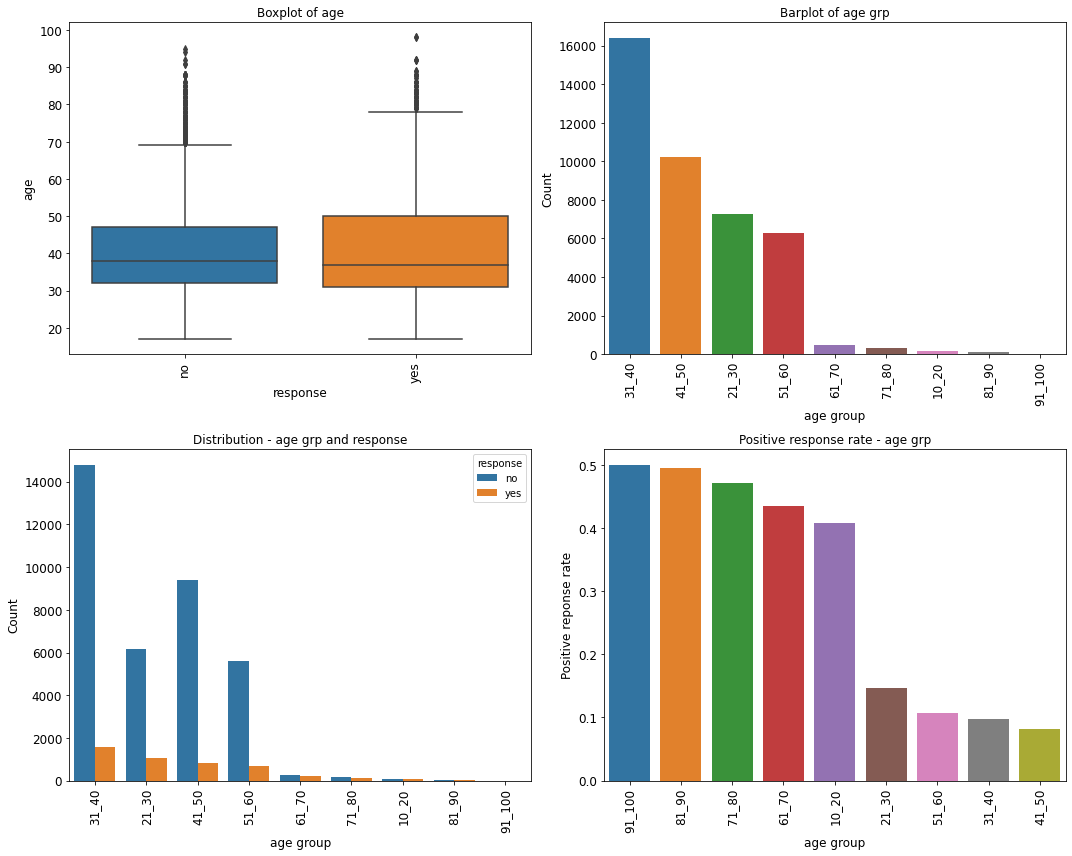

In [11]:
numerical_plot('age')

We observe that the clients that fall between the ages of 30 and 40 are contacted most often. They also offer the most number of positive and negative responses. It is difficult to assess whether age is a factor because not all age groups are equally represented in the dataset.

We notice that very young (less than 20) and older clients (over 60) are more likely to positively respond to a solicitation request. However, as previously noted, these effects may muted by the smaller sample sizes of these categories.

<b>Recommendation</b>: 
- Consider targeting older clients (over 60) during the marketing campaign.
- Target fewer number of clients between 40 and 50 years old.

## Influence of Job Category on Response

In [12]:
bank = response_rate_cat('job')

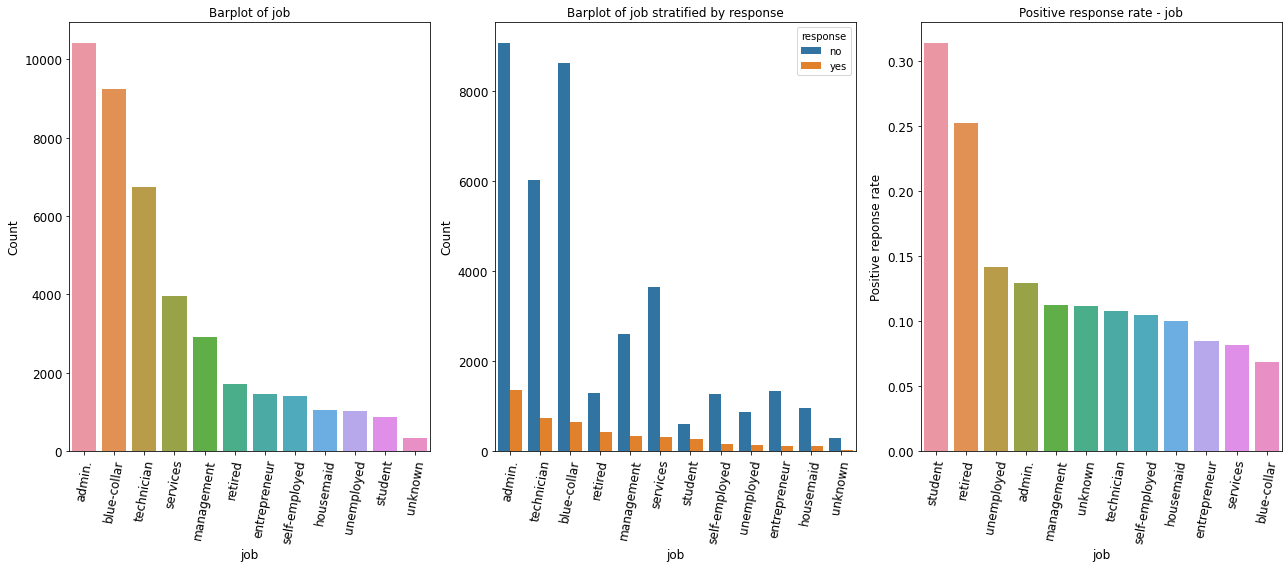

In [13]:
#Plot a histogram and bar chart for job category annotated with response
categorical_plot('job', rotation = 80)

Here we notice that those with admin, blue-collar and technician jobs are more likley to postively respond to the offer, although this effected may be muted due to the size of the aforementioned groups. We also notice that students have the highest positive response to the offer, followed by the retired, althought they represent a small proportion of the population.

<b>Recommendation</b>: 
- Target more students and retirees during the marketing campaing.
- Target fewer blue-collar workers. 

## Influence of Marital Status on subscription status

In [14]:
bank = response_rate_cat('marital')

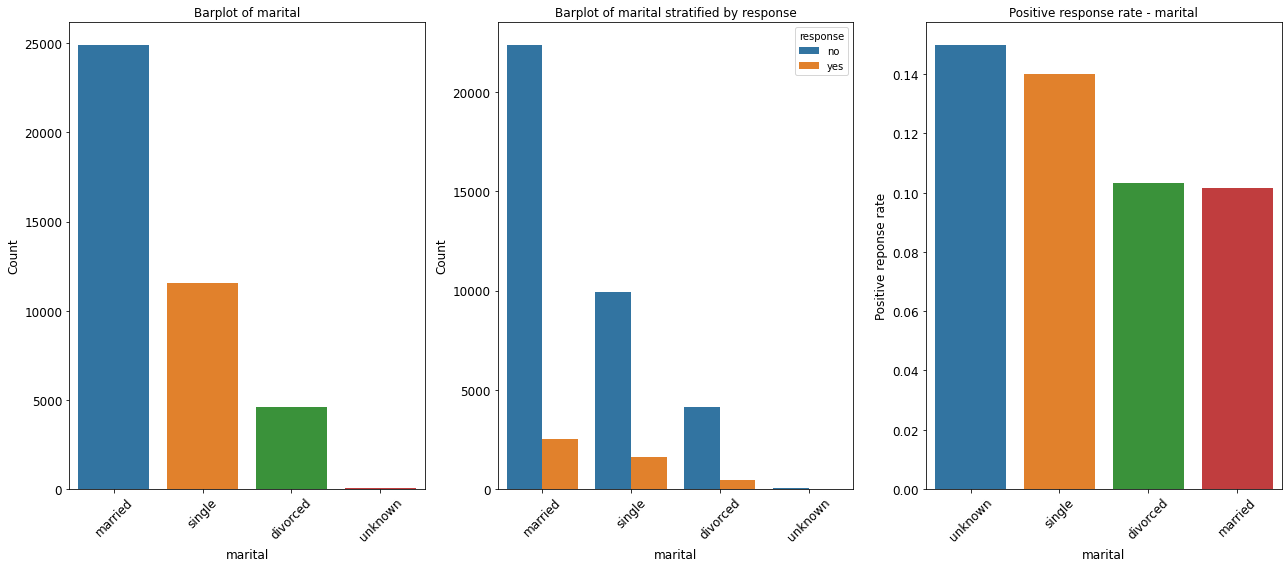

In [15]:
#Plot a histogram and bar chart for marital status category annotated with response
categorical_plot('marital', save = True)

More married people are targeted for the term-deposit. However, inspite of their higher proportion of overall positive response, single people are more likley to positively respond to the offer than any other known group. 

## Influence of Education-level on Subscription Status

In [16]:
bank = response_rate_cat('education')

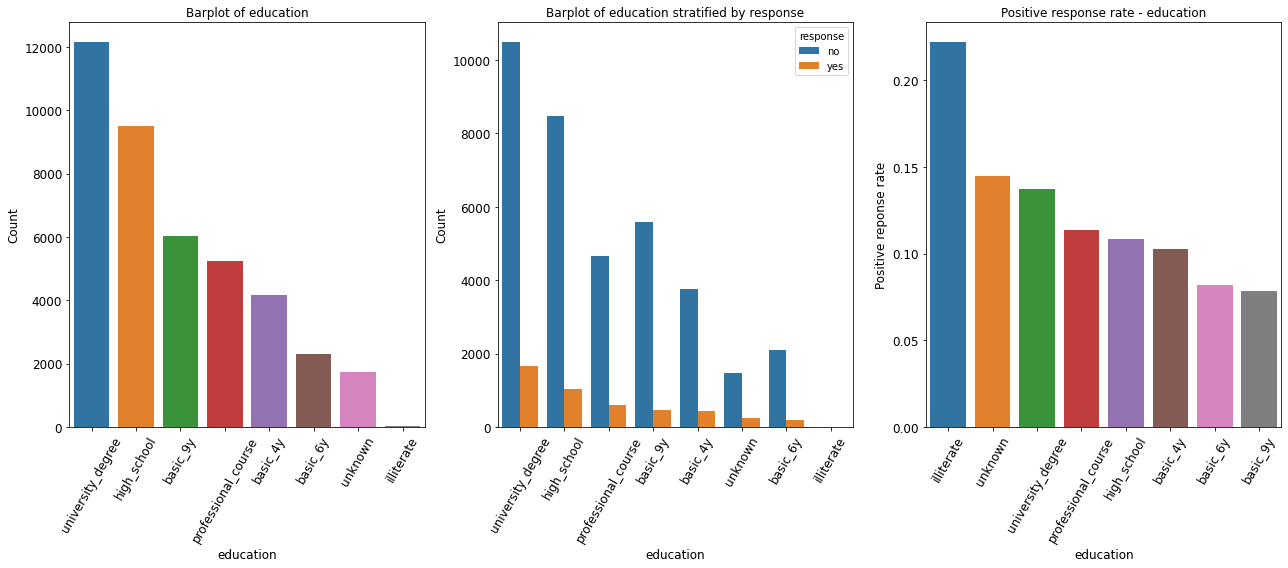

In [17]:
#Plot a histogram and bar chart for education level annotated with response
categorical_plot('education', rotation = 60)

Clients with a university degree are targeted and accept more offers than any other group. However, Illiterate peope are more likley to positively respond to an offer than any other group. This effect may be muted because of their low representation. 

<b>Recommendation:</b>
- Consider offering financial education service to clients referred to as 'illiterate' and encourage them to invest in a term-deposit account. 

# Influence of Financial History Variables on the Marketing Response

## Influence of Credit Default on Marketing Response

In [18]:
response_rate_cat('default')

,age,job,marital,education,default,housing,loan,contactType,month,dayOfWeek,...,cci,euribor3m,noEmployed,response,age_grp,age_grp_rr,job_rr,marital_rr,education_rr,default_rr
0,56,housemaid,married,basic_4y,no,no,no,telephone,may,mon,...,-36.4,4.857,5191.0,no,51_60,0.106539,0.100000,0.101573,0.102490,0.12879
1,57,services,married,high_school,unknown,no,no,telephone,may,mon,...,-36.4,4.857,5191.0,no,51_60,0.106539,0.081381,0.101573,0.108355,0.05153
2,37,services,married,high_school,no,yes,no,telephone,may,mon,...,-36.4,4.857,5191.0,no,31_40,0.097467,0.081381,0.101573,0.108355,0.12879
3,40,admin.,married,basic_6y,no,no,no,telephone,may,mon,...,-36.4,4.857,5191.0,no,31_40,0.097467,0.129726,0.101573,0.082024,0.12879
4,56,services,married,high_school,no,no,yes,telephone,may,mon,...,-36.4,4.857,5191.0,no,51_60,0.106539,0.081381,0.101573,0.108355,0.12879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional_course,no,yes,no,cellular,nov,fri,...,-50.8,1.028,4963.6,yes,71_80,0.471947,0.252326,0.101573,0.113485,0.12879
41184,46,blue-collar,married,professional_course,no,no,no,cellular,nov,fri,...,-50.8,1.028,4963.6,no,41_50,0.081738,0.068943,0.101573,0.113485,0.12879
41185,56,retired,married,university_degree,no,yes,no,cellular,nov,fri,...,-50.8,1.028,4963.6,no,51_60,0.106539,0.252326,0.101573,0.137245,0.12879
41186,44,technician,married,professional_course,no,no,no,cellular,nov,fri,...,-50.8,1.028,4963.6,yes,41_50,0.081738,0.108260,0.101573,0.113485,0.12879


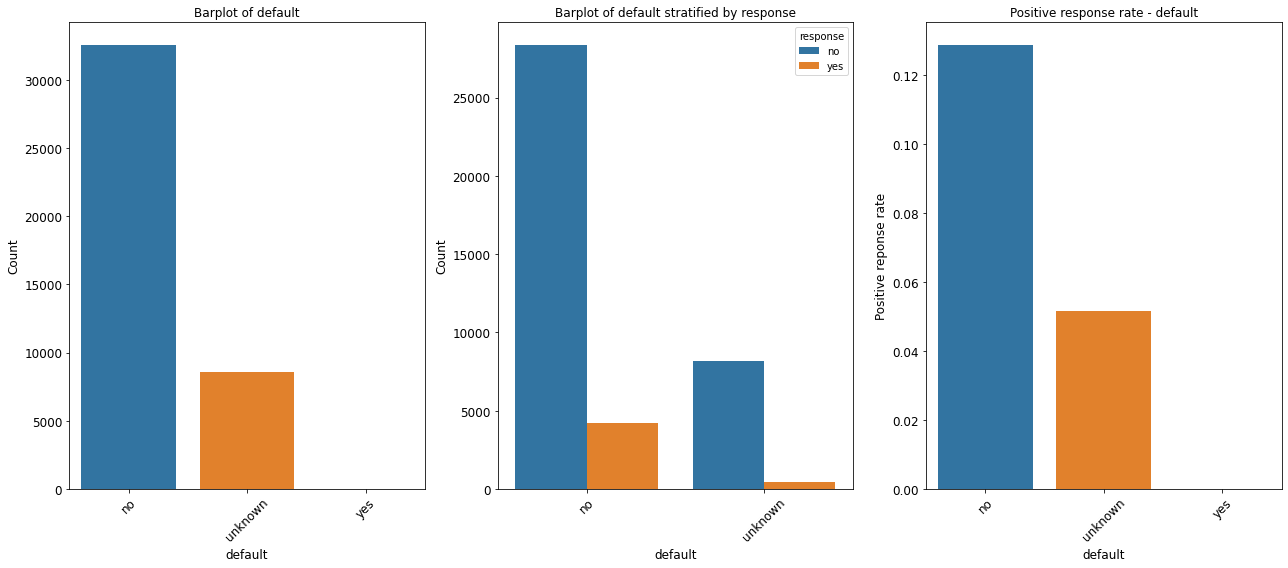

In [19]:
#Plot a histogram and bar chart for credit default annotated with response
categorical_plot('default')

Client who had not defaulted on their loan were targeted more than others. We observe that clients that have not defaulted on their credit are more likely to positively respond to the offer.

## Influence of Having a House Loan on Response

In [20]:
bank = response_rate_cat('housing')

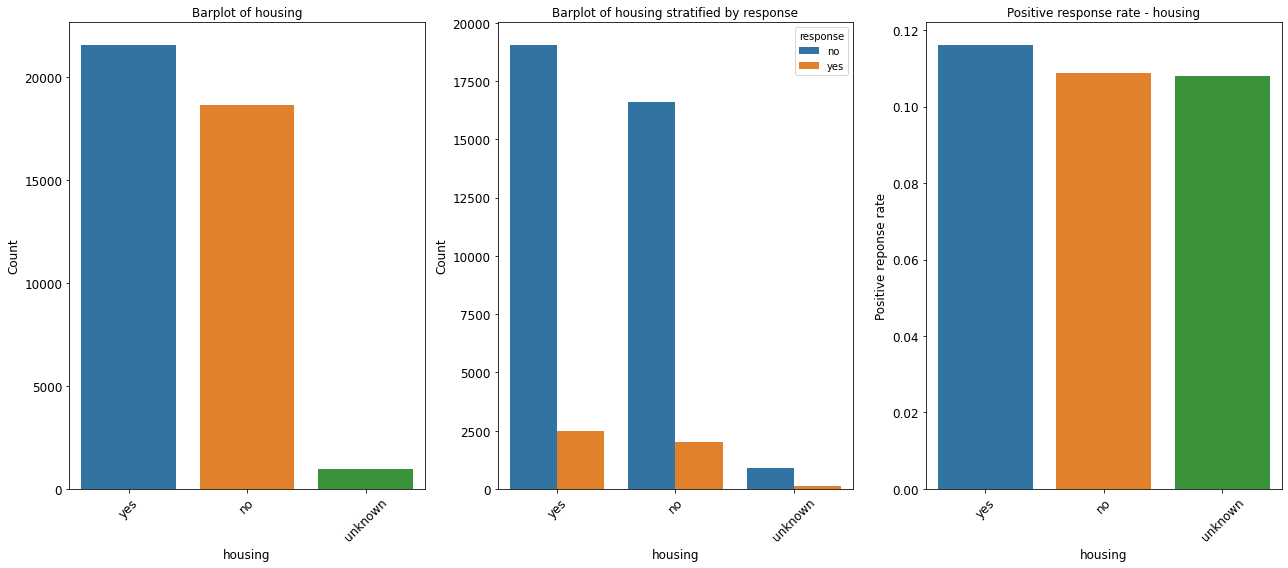

In [21]:
#Plot a histogram and bar chart for house loan annotated with response
categorical_plot('housing')

We observe that those with housing loans are more likely to positively respond to the offer, althought the gap is not wide. We also note that clients with a housing loan were targeted more often.

## Influence of Having a Personal Loan on Marketing Response

In [22]:
bank = response_rate_cat('loan')

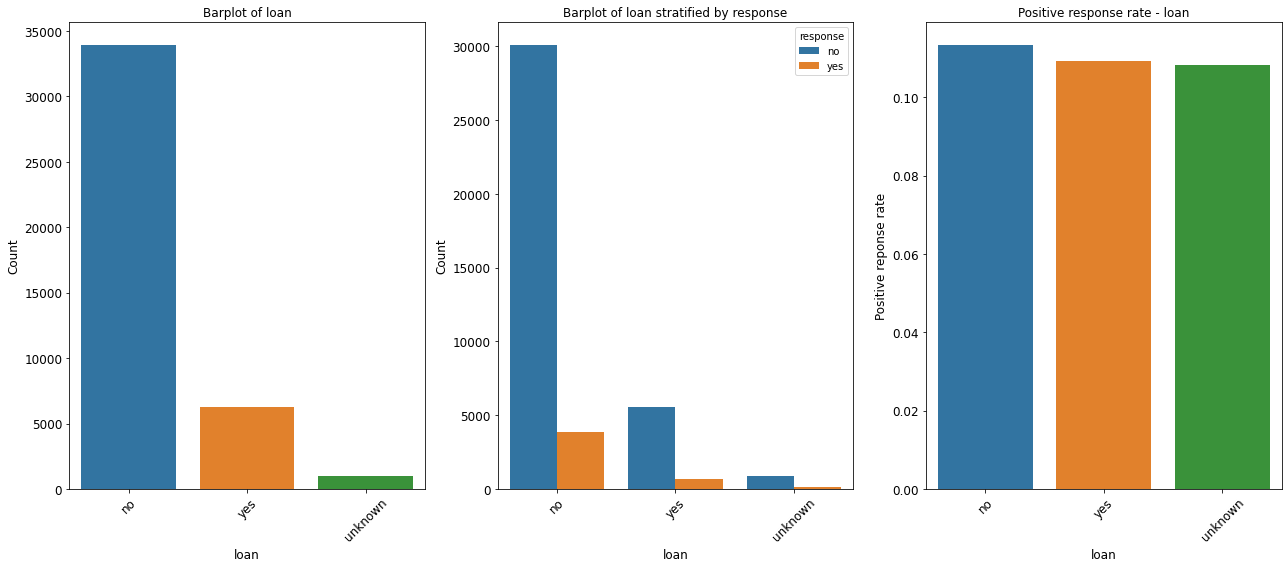

In [23]:
#Plot a histogram and bar chart for personal loan annotated with response
categorical_plot('loan')

Clients without a personal loan were targeted more than others. Although, individuals without a personal loan positively responded to offers than any other group, this distinction is not clear.

# Influence on Marketing Variables on Response

## Influence of contactType on Response

In [24]:
bank = response_rate_cat('contactType')

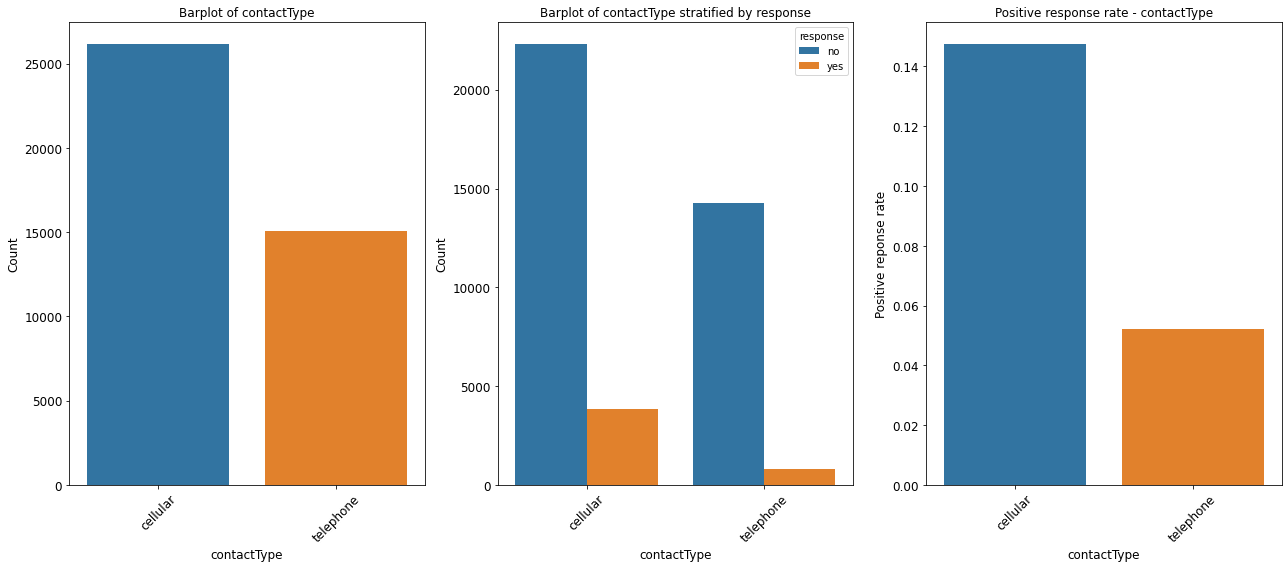

In [25]:
#Plot a histogram and bar chart for contact type annotated with response
categorical_plot('contactType')

Clients with a cell phone were contaced more and responded better to marketing initiatives. It should be noted that cellular phone users were more represented in the dataset.

In [26]:
bank.groupby('contactType')['response'].value_counts()

contactType  response
cellular     no          22291
             yes          3853
telephone    no          14257
             yes           787
Name: response, dtype: int64

## Influence of the Month of Contact on Response

In [27]:
bank = response_rate_cat('month')

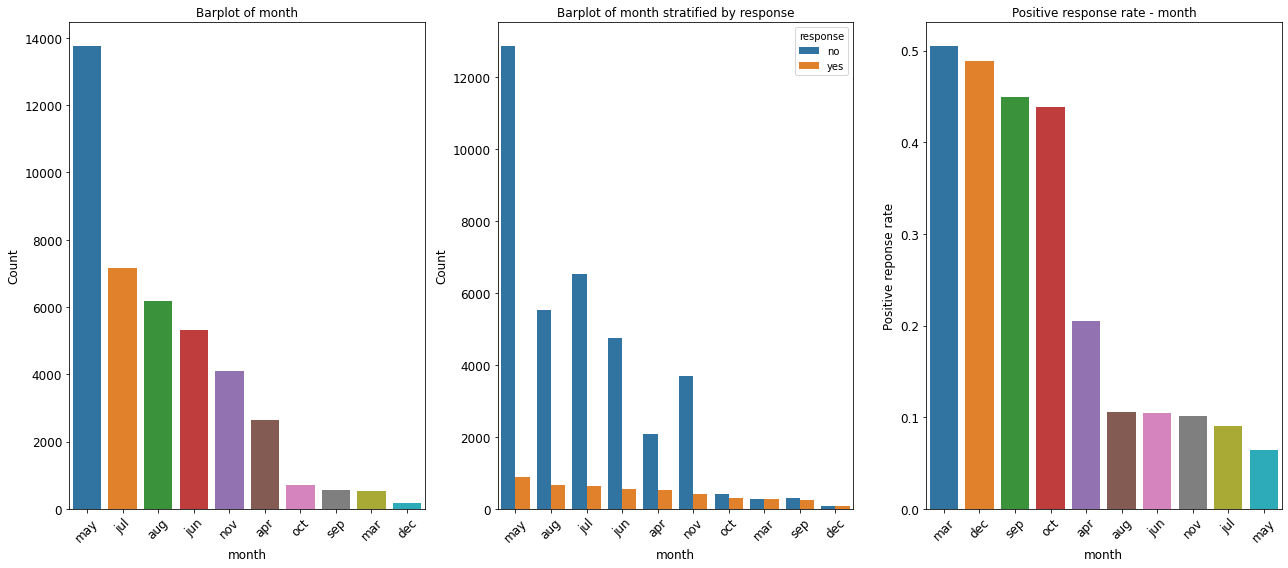

In [28]:
#Plot a histogram and bar chart for month contacted annotated with response
categorical_plot('month')

Clients were mostly contacted in May, but May has the lowest response rate. Contacts in March have the highest response rates, but is the second lowest period in which clients are contacted. This same trend holds for December when contacts are rarely made. 

<b>Recommendation:</b>
- Contact clients more often in March, December, September and October. 
- Reduce client contacts in May and July.

## Influence of dayOfWeek on Response

In [29]:
bank = response_rate_cat('dayOfWeek')

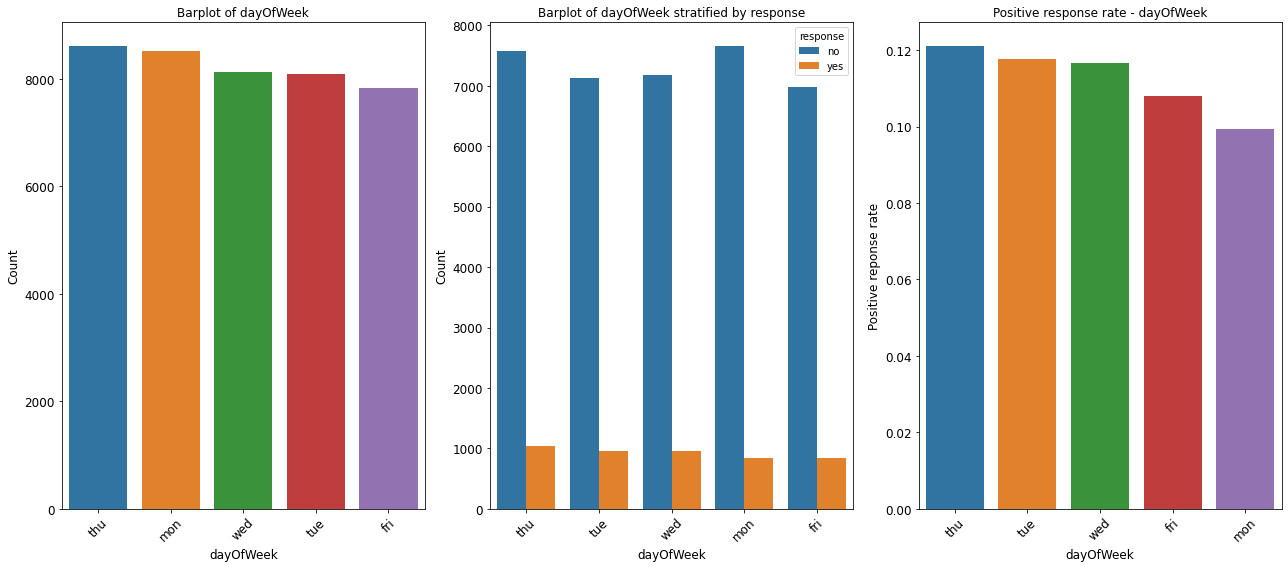

In [30]:
#Plot a histogram and bar chart for day of the week a client was contacted annotated with response
categorical_plot('dayOfWeek')

It seems contacts are almost equally made on all five days of the work week. The response rates for these days are similar, although responses are higher on Thursday.

## Influence of Duration of Call on Response

In [31]:
bank.duration.describe()

count    41188.000000
mean       258.285010
std        259.279249
min          0.000000
25%        102.000000
50%        180.000000
75%        319.000000
max       4918.000000
Name: duration, dtype: float64

In [32]:
#Create a duration group feature
duration_edges = [-1, 0, 100, 180, 320, 5000]
duration_labels = ['0', '1_100', '101_180', '181_320', '5001_5000']
bank = feature_group('duration', duration_edges, duration_labels)

In [33]:
#Check the 25th and 75th percentile values for a 'no' response
bank.loc[(bank.response == 'no'), 'duration'].quantile(0.25), bank.loc[(bank.response == 'no'), 'duration'].quantile(0.75)

(95.0, 279.0)

In [34]:
#Check the 25th and 75th percentile values for a 'yes' response
bank.loc[(bank.response == 'yes'), 'duration'].quantile(0.25), bank.loc[(bank.response == 'yes'), 'duration'].quantile(0.75)

(253.0, 741.25)

In [35]:
(bank.duration == 0).sum()

4

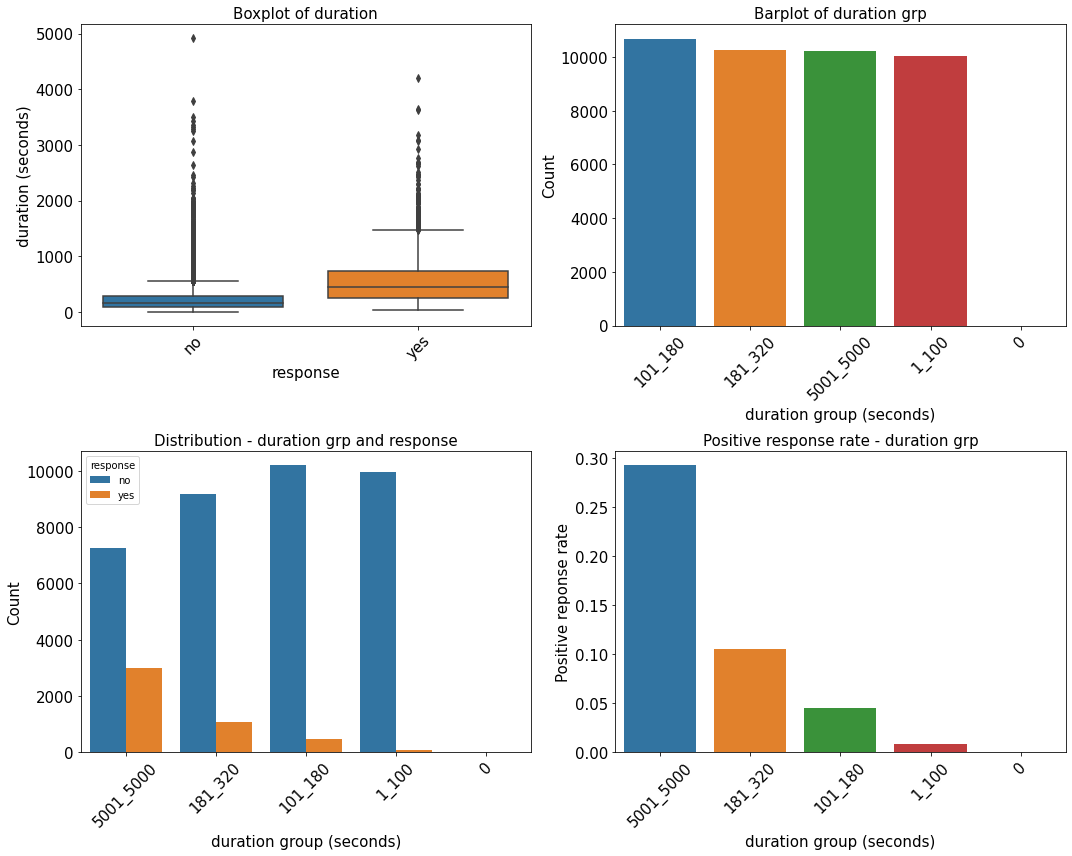

In [36]:
#Plot duration graphs
numerical_plot(feature = 'duration', figsize = (15, 12), rotation = 45, fontsize = 15, save = True, unit = 'seconds')

We notice that most of the calls between 0 and 600 seconds (10 minutes). However, this timeline yields the lowest response rate. The likelihood of acceptance further increases the longer duration of conversation.

<b>Recommendation:</b>
- Train call-center staff on ways to properly engage with clients during phone calls. The longer a client stays on the phone, the likely the client is to respond to the offer, but only up to a point. The sweet spot seems to be located between 20 and 50 minutes.

## Influence of the Current Number of Times a Client was Contacted and Response

In [37]:
#Review max and minimum values of currentCampaignContacts 
bank.currentCampaignContacts.min(), bank.currentCampaignContacts.max()

(1, 56)

In [38]:
#Create a currentCampaignContacts group feature
contact_edges = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 60]
contact_labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11_60']
bank = feature_group('currentCampaignContacts', contact_edges, contact_labels)

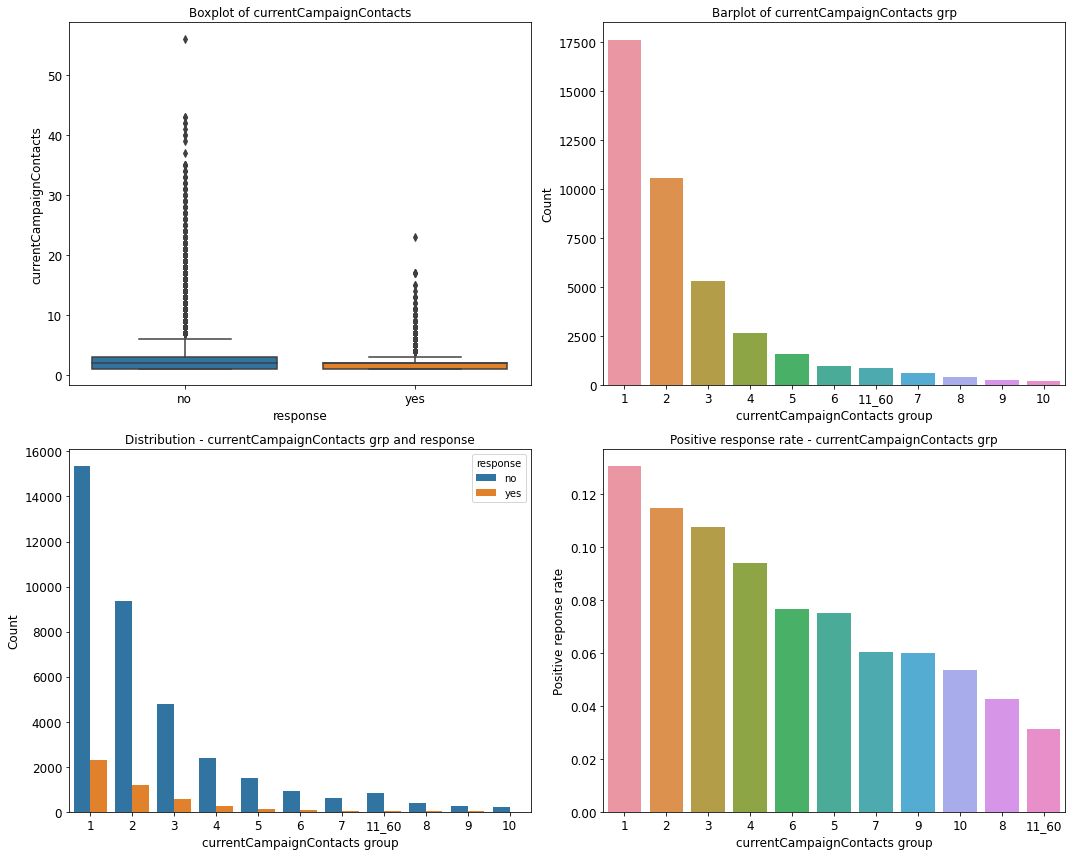

In [39]:
#Plot currentCampaignContacts graphs
numerical_plot(feature = 'currentCampaignContacts', rotation = 0, save = True)

We note that clients have been contacted mostly once and that the more a client is contacted the less likely it is that the client accepts the offer.

## Days Since a Client Was Contacted

In [40]:
#Summary statistics for daysLastContacted
bank.daysLastContacted.describe()

count    41188.000000
mean       962.475454
std        186.910907
min          0.000000
25%        999.000000
50%        999.000000
75%        999.000000
max        999.000000
Name: daysLastContacted, dtype: float64

In [41]:
bank.daysLastContacted.unique()

array([999,   6,   4,   3,   5,   1,   0,  10,   7,   8,   9,  11,   2,
        12,  13,  14,  15,  16,  21,  17,  18,  22,  25,  26,  19,  27,
        20], dtype=int64)

In [42]:
(bank.daysLastContacted == 0).sum()

15

In [43]:
lastContact_edges = [-1, 0, 7, 14, 28, 1000]
lastContact_labels = ['today', '7days', '14days', '21days', 'never']
bank = feature_group('daysLastContacted', lastContact_edges, lastContact_labels)

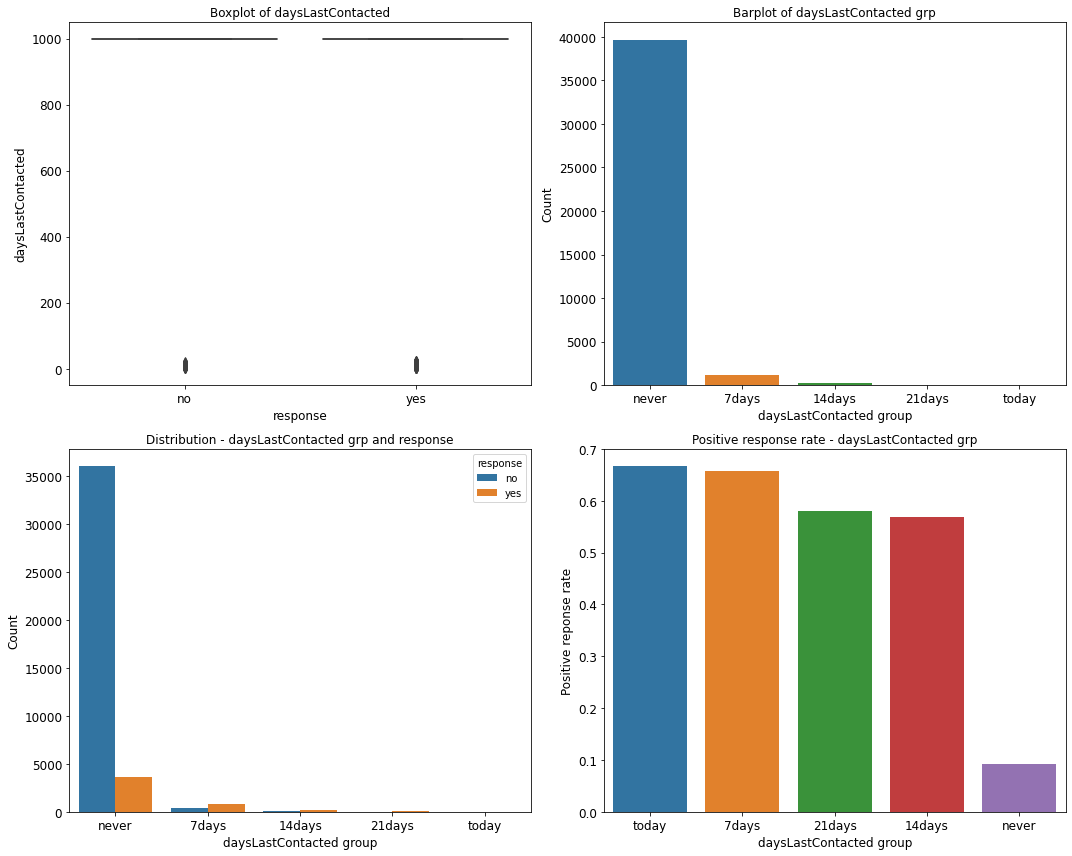

In [44]:
numerical_plot(feature = 'daysLastContacted', figsize = (15, 12), rotation = 0, fontsize = 12, save = True)

We note that most of the values in the dataset (over 90%) are 999 (meaning that many clients were contacted for the first time). The response rate within this group is low (about 1%). This feature does not have much variation and is likely to be dropped during modeling. 

## Number of Times a Client was Contacted in Previous Campaigns

In [45]:
#Summarystats for previousCampaignContacts
bank.previousCampaignContacts.describe()

count    41188.000000
mean         0.172963
std          0.494901
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          7.000000
Name: previousCampaignContacts, dtype: float64

In [46]:
previousContact_edges = [-1, 0, 1, 2, 3, 4, 5, 6, 7]
previousContact_labels = ['0', '1', '2', '3', '4', '5', '6', '7']
bank = feature_group('previousCampaignContacts', previousContact_edges, previousContact_labels)

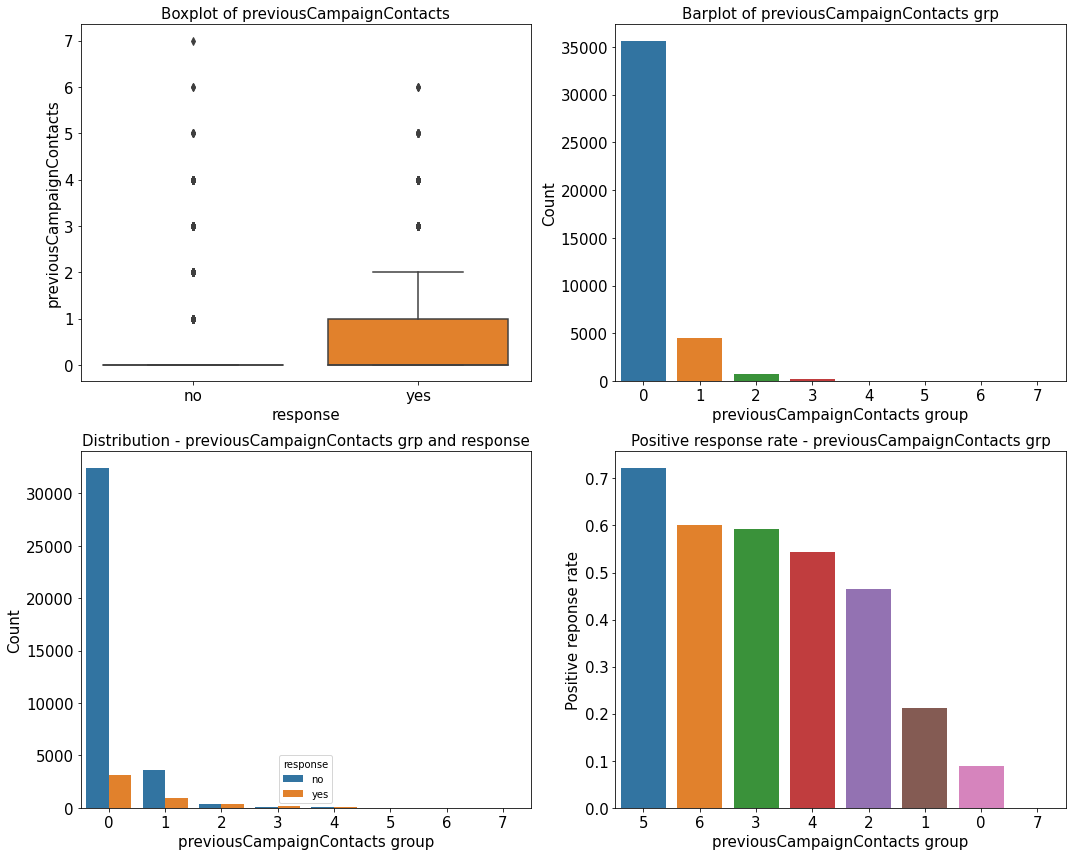

In [47]:
numerical_plot(feature = 'previousCampaignContacts', rotation = 0, figsize = (15, 12), fontsize = 15, save = True)

Most clients were not contacted during the previoius campaigns. We observe that positive responses are likely from those who were actually contacted during previous campaigns.

<b>Recommendation:</b>
- Select the most skilled staff to contact clients that have been previously contacted between 2 and 5 times. These clients seem to offer the most positive responses.

## Outcome of the Last Campaign

In [48]:
bank = response_rate_cat('lastCampaignOutcome')

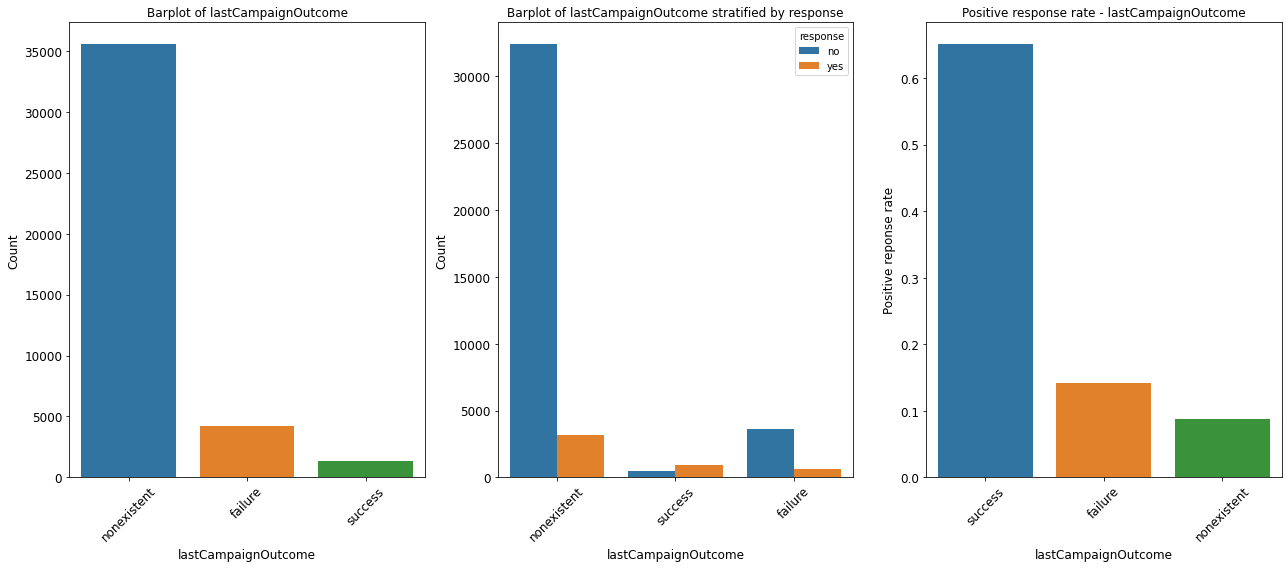

In [49]:
categorical_plot('lastCampaignOutcome')

We observe that most clients were not contacted during the last campaign and for those who were contacted, most clients did not sign-up for the term-deposit. We also observe that clients that sign-up for deposits during the last campaign were more likely to sign-up for deposits during the current campaign. 

<b>Recommendation:</b>
- Select the most skilled staff to contact clients that have previously responded positively to the marketing request. These clients seem to offer the most positive responses.

# Influence of MacroEconomic Variables on Response

## Influence of Employment Rate on Response

In [50]:
#Summary stats for employmentRate
bank.employmentRate.describe()

count    41188.000000
mean         0.081886
std          1.570960
min         -3.400000
25%         -1.800000
50%          1.100000
75%          1.400000
max          1.400000
Name: employmentRate, dtype: float64

In [51]:
employment_edges = [-3.5, -3, -2.5, -1.5, -1, 0, 1.5]
employment_labels = ['neg3.5_neg3', 'neg2.9_neg2.5', 'neg2.4_neg1.5', 'neg1.4_neg1', 'neg0.9_0', '0.1_1.5' ]
bank = feature_group('employmentRate', employment_edges, employment_labels)

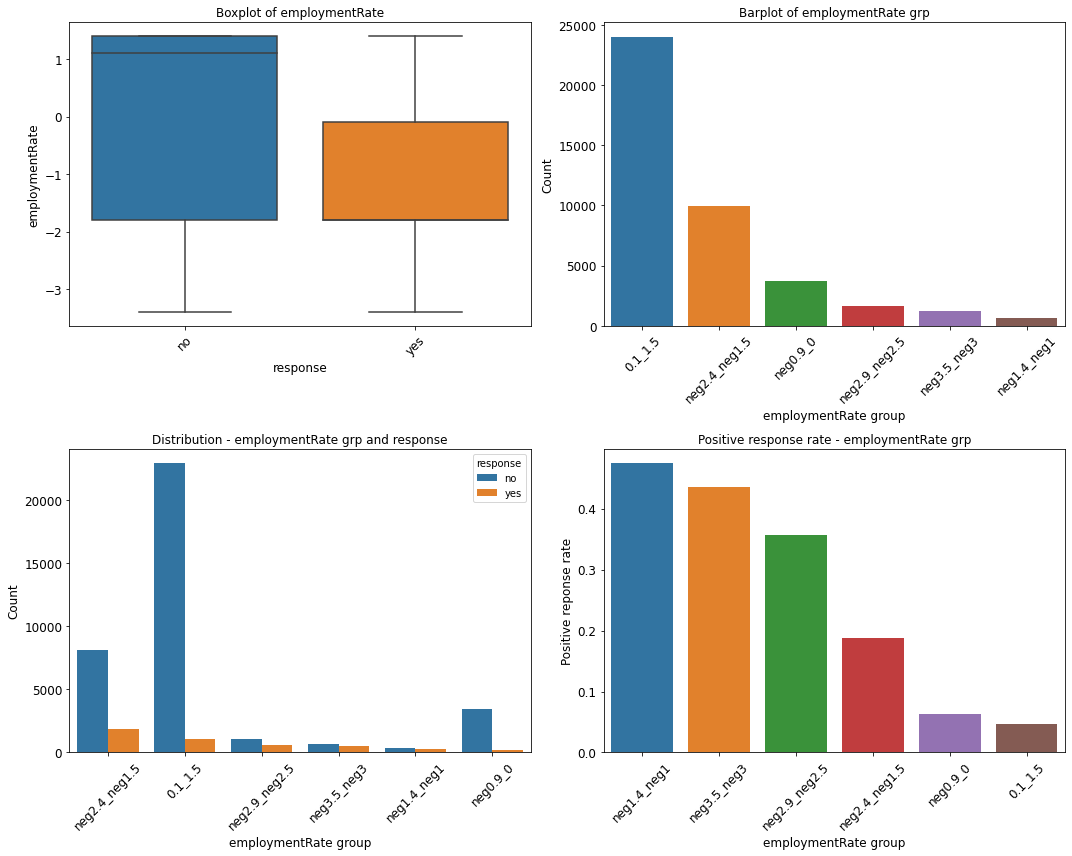

In [52]:
numerical_plot('employmentRate', rotation = 45)

Employment rate typically fluctuates between -2% and 1.5%, with an employment rate of between 1 and 1.5% observed over 50% of the time. We however notice that favorable responses to term-deposit requests typically occur when the employment rate is negative (when more people are looking for a job). Perhaps clients are incentivized to save more when the economic environment is unfavorable.

<b>Recommendation:</b>
- Contact clients when the employment rate is negative. It seems clients tend to positively respond to savings request during these periods.

In [53]:
bank[(bank.employmentRate == 1.4)].head()

,age,job,marital,education,default,housing,loan,contactType,month,dayOfWeek,...,duration_grp_rr,currentCampaignContacts_grp,currentCampaignContacts_grp_rr,daysLastContacted_grp,daysLastContacted_grp_rr,previousCampaignContacts_grp,previousCampaignContacts_grp_rr,lastCampaignOutcome_rr,employmentRate_grp,employmentRate_grp_rr
7763,26,management,single,university_degree,no,no,no,telephone,jun,mon,...,0.008081,3,0.107471,never,0.092582,0,0.088322,0.088322,0.1_1.5,0.046089
7764,42,technician,married,professional_course,unknown,no,no,telephone,jun,mon,...,0.045233,9,0.060071,never,0.092582,0,0.088322,0.088322,0.1_1.5,0.046089
7765,30,admin.,married,university_degree,no,no,no,telephone,jun,mon,...,0.008081,2,0.114570,never,0.092582,0,0.088322,0.088322,0.1_1.5,0.046089
7766,55,technician,married,basic_9y,no,no,no,telephone,jun,mon,...,0.008081,3,0.107471,never,0.092582,0,0.088322,0.088322,0.1_1.5,0.046089
7767,41,blue-collar,married,basic_4y,no,yes,no,telephone,jun,mon,...,0.045233,2,0.114570,never,0.092582,0,0.088322,0.088322,0.1_1.5,0.046089


In [54]:
bank.employmentRate_grp.unique()

['0.1_1.5', 'neg0.9_0', 'neg2.4_neg1.5', 'neg2.9_neg2.5', 'neg3.5_neg3', 'neg1.4_neg1']
Categories (6, object): ['neg3.5_neg3' < 'neg2.9_neg2.5' < 'neg2.4_neg1.5' < 'neg1.4_neg1' < 'neg0.9_0' < '0.1_1.5']

## Influence of Consumer Price Index on Response

In [55]:
#Summary stats for cpi
bank.cpi.describe()

count    41188.000000
mean        93.575664
std          0.578840
min         92.201000
25%         93.075000
50%         93.749000
75%         93.994000
max         94.767000
Name: cpi, dtype: float64

In [56]:
bank.cpi.unique()

array([93.994, 94.465, 93.918, 93.444, 93.798, 93.2  , 92.756, 92.843,
       93.075, 92.893, 92.963, 92.469, 92.201, 92.379, 92.431, 92.649,
       92.713, 93.369, 93.749, 93.876, 94.055, 94.215, 94.027, 94.199,
       94.601, 94.767])

In [57]:
cpi_edges = [92,93, 94, 95]
cpi_labels = ['92_93', '93.001_94', '94.001_95']
bank = feature_group('cpi', cpi_edges, cpi_labels)

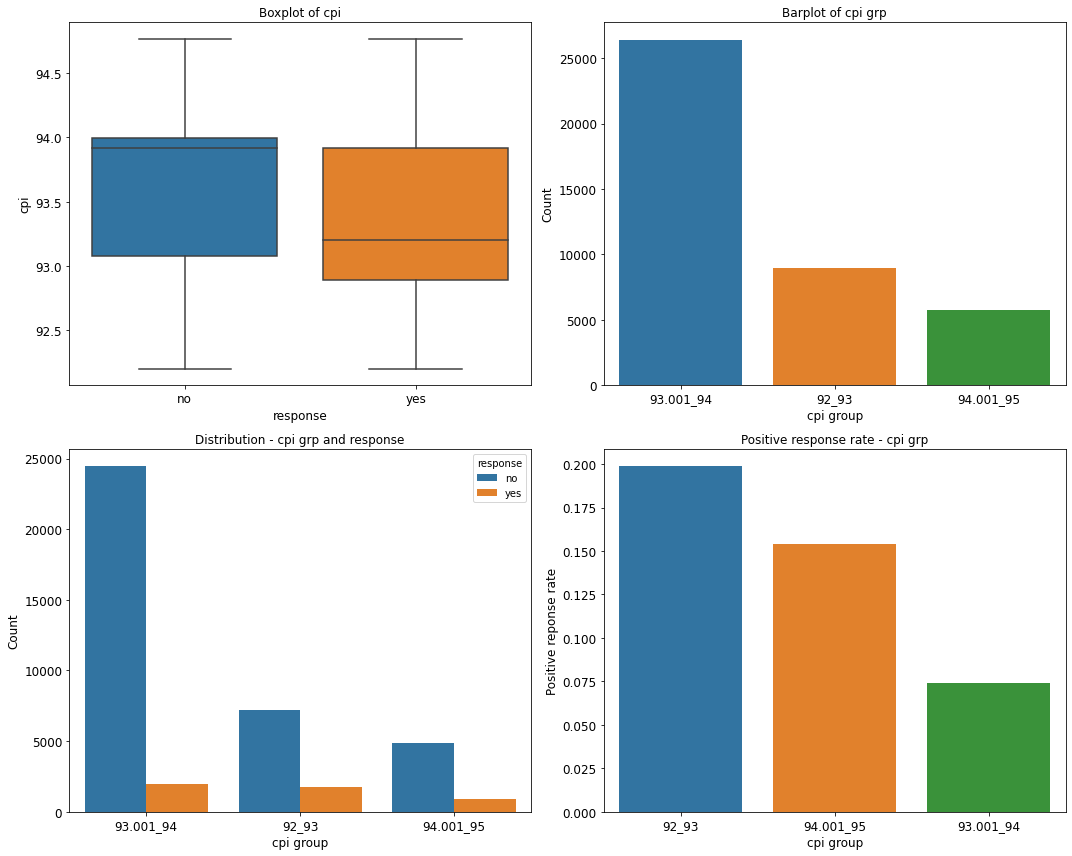

In [58]:
numerical_plot('cpi', rotation = 0)

We note that cpi is typically between 93 and 94, with more marketing solicitations made when the cpi was between 93.5 and 94. The best responses occured when the cpi was between 92 and 92.5.

## Influence of Consumer Condfidence Index on Response

In [59]:
#Summary stats for Consumer Confidence Index
bank.cci.describe()

count    41188.000000
mean       -40.502600
std          4.628198
min        -50.800000
25%        -42.700000
50%        -41.800000
75%        -36.400000
max        -26.900000
Name: cci, dtype: float64

In [60]:
bank.cci.unique()

array([-36.4, -41.8, -42.7, -36.1, -40.4, -42. , -45.9, -50. , -47.1,
       -46.2, -40.8, -33.6, -31.4, -29.8, -26.9, -30.1, -33. , -34.8,
       -34.6, -40. , -39.8, -40.3, -38.3, -37.5, -49.5, -50.8])

In [61]:
cci_edges = [-51, -46, -41, -36, -31, -26]
cci_labels = ['neg51_neg46', 'neg45.9_neg41', 'neg40.9_neg36', 'neg35.9_neg31', 'neg30.9_neg26']
bank = feature_group('cci', cci_edges, cci_labels)

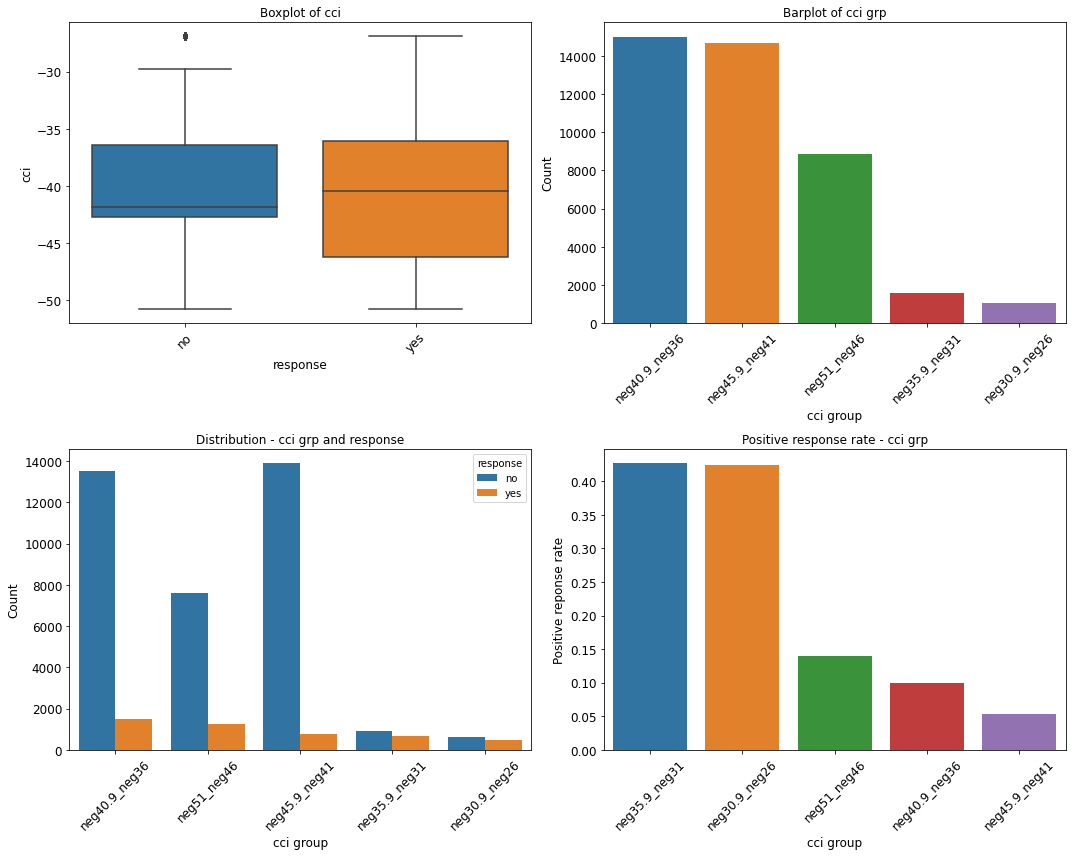

In [62]:
numerical_plot('cci', rotation = 45)

We note that the confidence index is typically between -45 and -35, with more marketing solicitations made when the confidence was between -37.5 and -35. The best responses occured when the confidence index was between -35 and -32.5.

## Influence of 3-month Euribor rate and Response

In [63]:
bank.euribor3m.describe()

count    41188.000000
mean         3.621291
std          1.734447
min          0.634000
25%          1.344000
50%          4.857000
75%          4.961000
max          5.045000
Name: euribor3m, dtype: float64

In [64]:
bank.euribor3m.unique()[:20]

array([4.857, 4.856, 4.855, 4.859, 4.86 , 4.858, 4.864, 4.865, 4.866,
       4.967, 4.961, 4.959, 4.958, 4.96 , 4.962, 4.955, 4.947, 4.956,
       4.966, 4.963])

In [65]:
euribor_edges = [0.6, 1.5, 2.4, 3.3, 4.2, 5.1]
euribor_labels = ['0.6_1.5', '1.501_2.4', '2.401_3.3', '3.301_4.2', '4.201_5.1']
bank = feature_group('euribor3m', euribor_edges, euribor_labels)

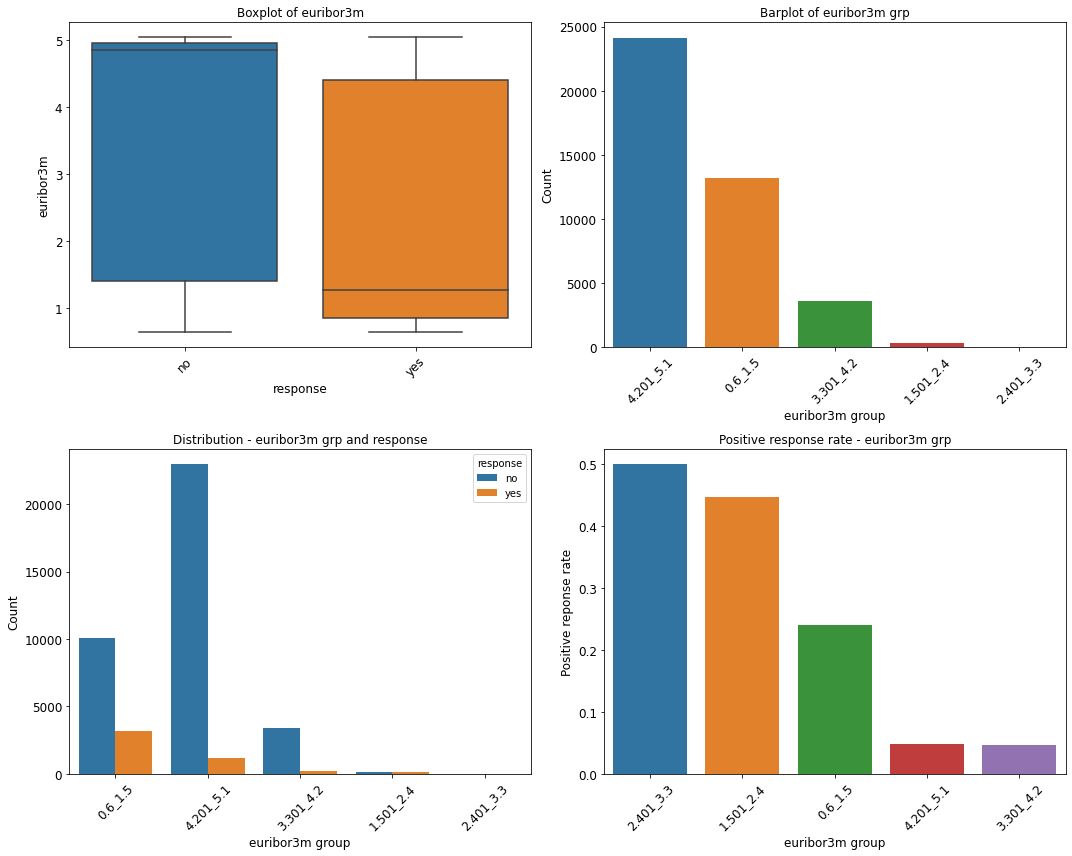

In [66]:
numerical_plot('euribor3m', rotation = 45)

We note that the 3-month euribor rate is typically between 1 and 5, with more marketing solicitations made when the rate was between 4.5 and 5 (when the rate was highest). Interestingly, most positive responses occured when the interest rates were between 0.5 and 3.5 (relatively low).

<b>Recommendation:</b>
- Train staff to highlight the importance of investing when euribor rate is high. There is less uptake during these periods.

## Influence of number of people employed and response

In [67]:
#Summary stats for noEmployed
bank.noEmployed.describe()

count    41188.000000
mean      5167.035911
std         72.251528
min       4963.600000
25%       5099.100000
50%       5191.000000
75%       5228.100000
max       5228.100000
Name: noEmployed, dtype: float64

In [68]:
bank.noEmployed.unique()[:20]

array([5191. , 5228.1, 5195.8, 5176.3, 5099.1, 5076.2, 5017.5, 5023.5,
       5008.7, 4991.6, 4963.6])

In [69]:
noEmployed_edges = noEmployed_edges = [4960, 5050, 5140, 5230]
noEmploywed_labels = ['4960_5050', '5050.1_5140', '5140.1_5230']
bank = feature_group('noEmployed', noEmployed_edges, noEmploywed_labels)

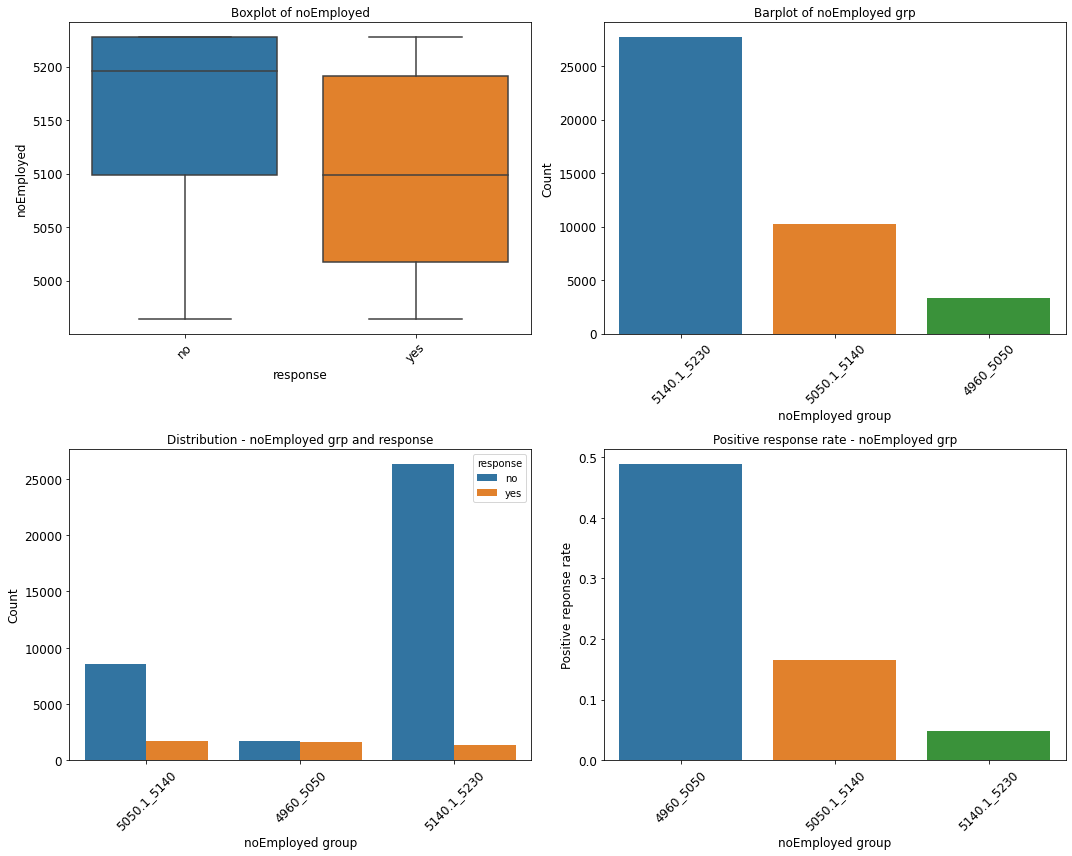

In [70]:
numerical_plot( 'noEmployed', rotation = 45)

We note that the number of employees is typically between 5025 and 5250, with more marketing solicitations made when the number of employees is between 5025 and 5200.

# Relationship Between Features

## Consumer Confidence Index Vs. Consumer Price Index

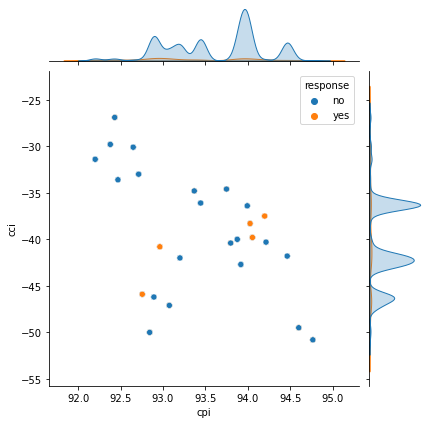

In [71]:
#Consumer Price Index versus Consumer Confidence Index
sns.jointplot(data = bank, x = 'cpi', y = 'cci', hue = 'response');

There is no obvious relationship between cci and cpi.

## Employment Rate Vs. 3-Month Euribor rate

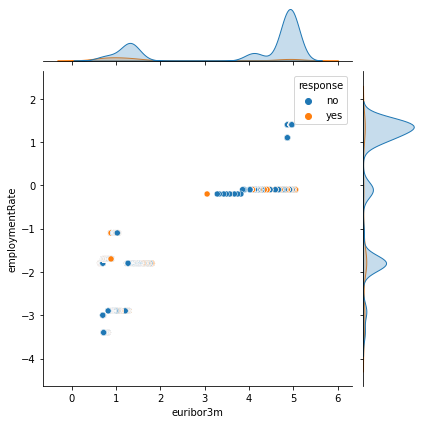

In [72]:
#Plot relationship between employmentRate and euribor3m
sns.jointplot(data = bank, x = 'euribor3m', y = 'employmentRate', hue = 'response');

We observe that as the employment rate increases the euribor rate seems to increase.

## Relationship Between All Numerical Variables

In [73]:
#sns.pairplot(bank, hue = 'response');

## Heatmap of Correlation Coefficients

In [74]:
df_heatmap = bank.copy()

In [75]:
df_heatmap.response = df_heatmap.response.replace({'yes': 1, 'no': 0})

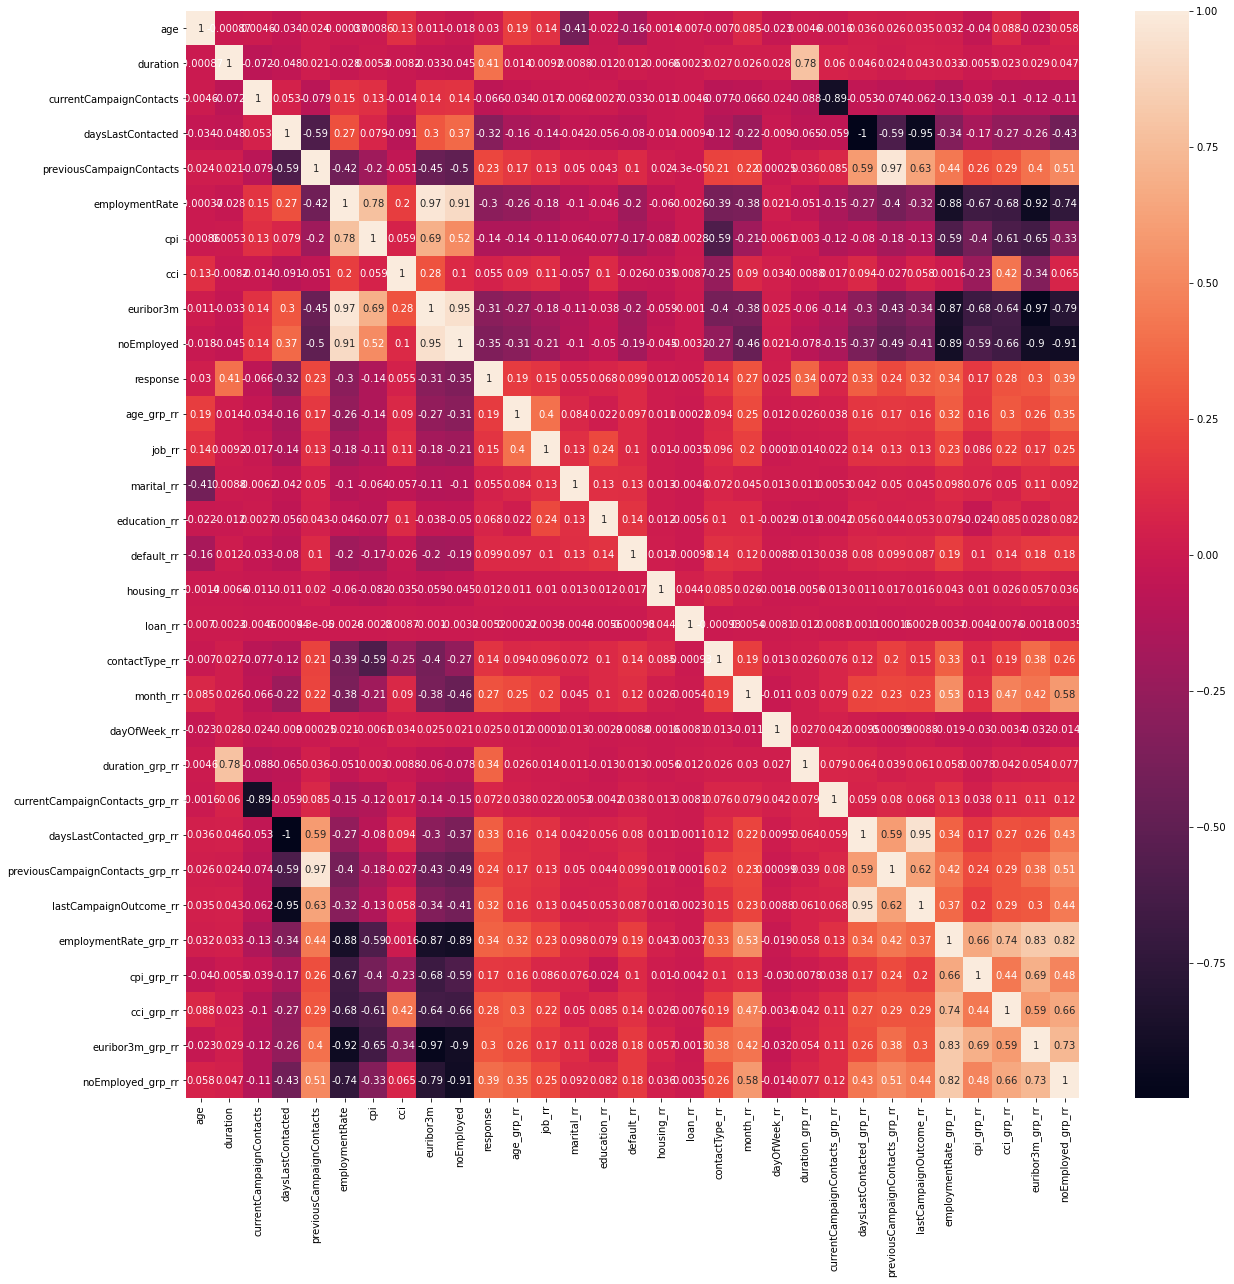

In [76]:
plt.figure(figsize = (20, 20))
sns.heatmap(df_heatmap.corr(), annot = True);

We note that there is a high correlation between duration and response. The data owner noted this high correlation given that a no duration necessarily implies no response. The duration feature must be removed during modeling.

We see that previousCampaignContacts positively correlates with response. Similarly, the euribor rate, number employed, employment rate have a relatively high negative correlation with response.

Possible collinearities include the high correlation between the employment rate and cpi; number of employees and employment rate; euribor rate and employment rate.

Feature that have a weak correlation with the response include cci and currentCampaignContacts.

In [77]:
bank.head()

,age,job,marital,education,default,housing,loan,contactType,month,dayOfWeek,...,employmentRate_grp,employmentRate_grp_rr,cpi_grp,cpi_grp_rr,cci_grp,cci_grp_rr,euribor3m_grp,euribor3m_grp_rr,noEmployed_grp,noEmployed_grp_rr
0,56,housemaid,married,basic_4y,no,no,no,telephone,may,mon,...,0.1_1.5,0.046089,93.001_94,0.074241,neg40.9_neg36,0.099414,4.201_5.1,0.048503,5140.1_5230,0.048357
1,57,services,married,high_school,unknown,no,no,telephone,may,mon,...,0.1_1.5,0.046089,93.001_94,0.074241,neg40.9_neg36,0.099414,4.201_5.1,0.048503,5140.1_5230,0.048357
2,37,services,married,high_school,no,yes,no,telephone,may,mon,...,0.1_1.5,0.046089,93.001_94,0.074241,neg40.9_neg36,0.099414,4.201_5.1,0.048503,5140.1_5230,0.048357
3,40,admin.,married,basic_6y,no,no,no,telephone,may,mon,...,0.1_1.5,0.046089,93.001_94,0.074241,neg40.9_neg36,0.099414,4.201_5.1,0.048503,5140.1_5230,0.048357
4,56,services,married,high_school,no,no,yes,telephone,may,mon,...,0.1_1.5,0.046089,93.001_94,0.074241,neg40.9_neg36,0.099414,4.201_5.1,0.048503,5140.1_5230,0.048357


In [78]:
bank.isnull().sum()

age                                0
job                                0
marital                            0
education                          0
default                            0
housing                            0
loan                               0
contactType                        0
month                              0
dayOfWeek                          0
duration                           0
currentCampaignContacts            0
daysLastContacted                  0
previousCampaignContacts           0
lastCampaignOutcome                0
employmentRate                     0
cpi                                0
cci                                0
euribor3m                          0
noEmployed                         0
response                           0
age_grp                            0
age_grp_rr                         0
job_rr                             0
marital_rr                         0
education_rr                       0
default_rr                         0
h

# Saving DataFrame

In [79]:
datapath = '..\data\interim'
datapath_bank = os.path.join(datapath, 'bank_modeling.csv')
bank.to_csv(datapath_bank, index=False)